In [68]:
!pip install unidecode

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import re
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import unidecode
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\avich\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [70]:
df_train = pd.read_json("C:\\Users\\avich\\OneDrive\\Documents\\train.json")
df_train

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."


In [71]:
df_test = pd.read_json("C:\\Users\\avich\\OneDrive\\Documents\\test.json")
df_test

,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."
...,...,...
9939,30246,"[large egg yolks, fresh lemon juice, sugar, bo..."
9940,36028,"[hot sauce, butter, sweet potatoes, adobo sauc..."
9941,22339,"[black pepper, salt, parmigiano reggiano chees..."
9942,42525,"[cheddar cheese, cayenne, paprika, plum tomato..."


In [72]:
print("Total Cuisines:",df_train['cuisine'].nunique())

Total Cuisines: 20


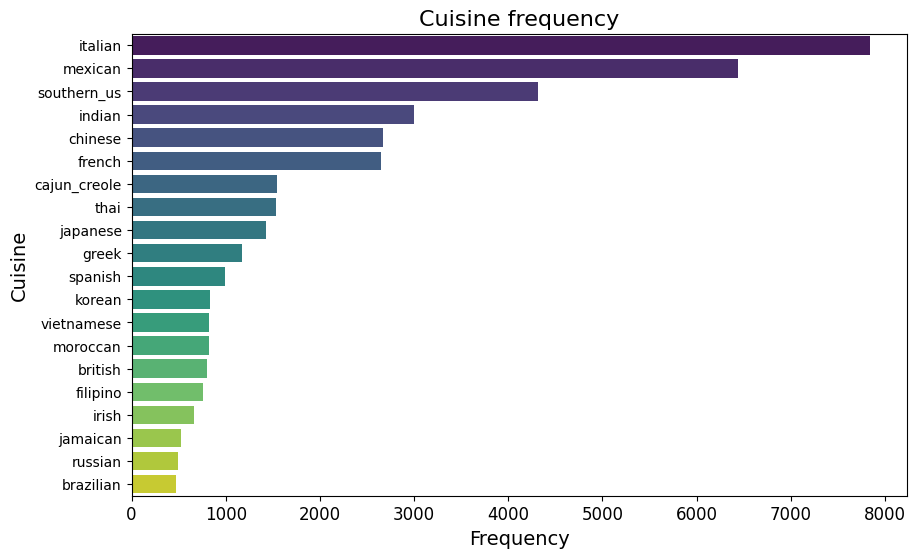

In [73]:
cuisine_counts = df_train['cuisine'].value_counts()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(y=cuisine_counts.index, x=cuisine_counts.values, palette="viridis", orient='h')
plt.title('Cuisine frequency', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Cuisine', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.show()

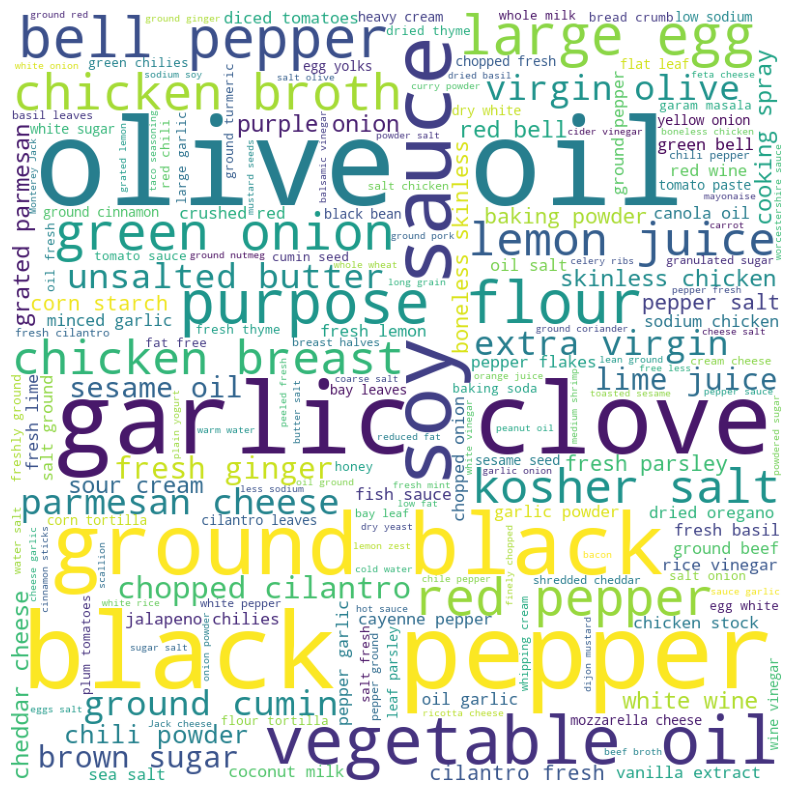

In [74]:

# Combining all ingredients into a single string for the word cloud
all_ingredients = ', '.join([', '.join(ingredients) for ingredients in df_train['ingredients']])

# Creating a Word Cloud for the ingredients
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(all_ingredients)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 1)

plt.show()

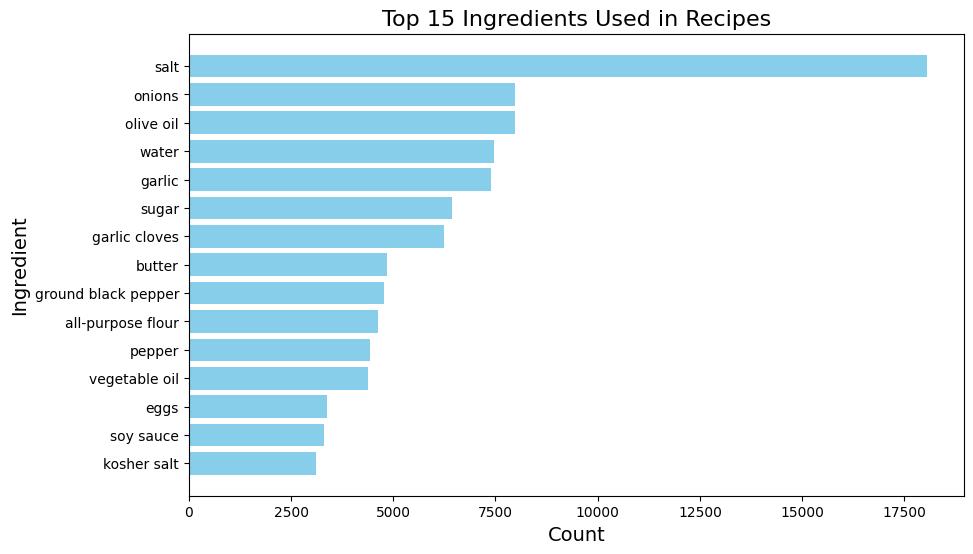

In [75]:
all_ingredients = [ingredient for sublist in df_train['ingredients'] for ingredient in sublist]
ingredient_counts = Counter(all_ingredients)

# Sort and get the top 10 ingredients
top_ingredients = ingredient_counts.most_common(15)

# Separate keys and values for plotting
ingredients, counts = zip(*top_ingredients)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(ingredients, counts, color='skyblue')
plt.xlabel('Count', fontsize=14)
plt.ylabel('Ingredient', fontsize=14)
plt.title('Top 15 Ingredients Used in Recipes', fontsize=16)
plt.gca().invert_yaxis()
plt.show()

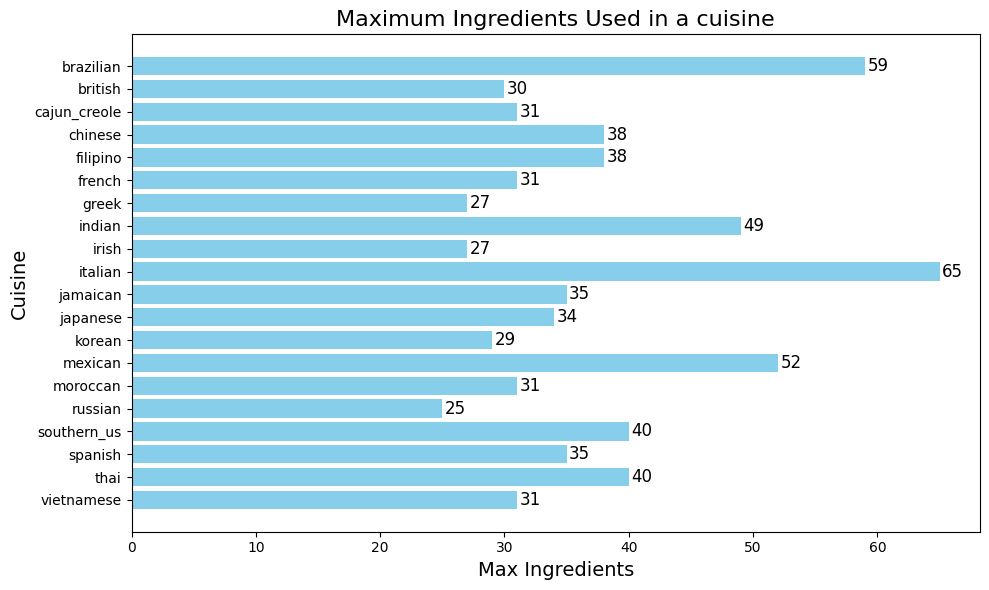

In [76]:
# Max ingredients used in each cuisine
max_ingredients_per_cuisine = (
    df_train.groupby('cuisine')['ingredients']
    .apply(lambda x: max(len(ingredients) for ingredients in x))
)
# Convert to a DataFrame for better handling
max_ingredients_df = max_ingredients_per_cuisine.reset_index()
max_ingredients_df.columns = ['Cuisine', 'Max Ingredients']

# Plot a horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(max_ingredients_df['Cuisine'], max_ingredients_df['Max Ingredients'], color='skyblue')

# Add labels at the end of each bar
for bar in bars:
    width = bar.get_width()  # Get the length of the bar
    plt.text(
        width + 0.2,  # Position the label slightly beyond the end of the bar
        bar.get_y() + bar.get_height() / 2,  # Center the label vertically
        str(int(width)),  # Convert the value to an integer and display as text
        va='center',  # Align vertically at the center
        fontsize=12  # Set font size
    )

plt.xlabel('Max Ingredients', fontsize=14)
plt.ylabel('Cuisine', fontsize=14)
plt.title('Maximum Ingredients Used in a cuisine', fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout()
plt.show()

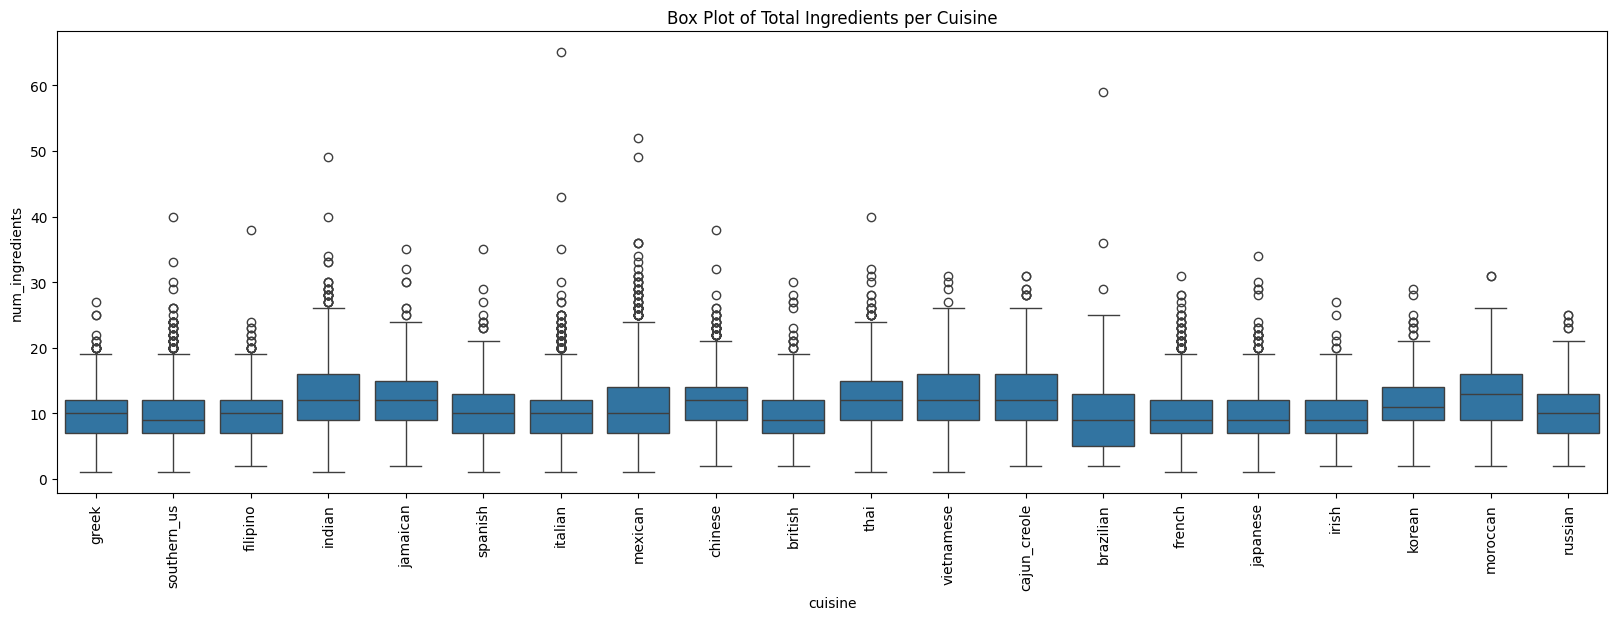

In [77]:
df_train['num_ingredients'] = df_train['ingredients'].apply(lambda x: len(x))

# Step 2: Group by cuisine and create the box plot
plt.figure(figsize=(20, 6))
sns.boxplot(x='cuisine', y='num_ingredients', data=df_train)
plt.title('Box Plot of Total Ingredients per Cuisine')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.show()

In [78]:
# Count ingredients that contain numbers
special_number = set()

# Iterate over the ingredients column
for ingredient_list in df_train["ingredients"]:
    for ingredient in ingredient_list:
        if re.findall("[0-9]", ingredient):  # Check if the ingredient contains numbers
            special_number.add(ingredient)

# Output the results
print("Ingredients containing numbers:", special_number)
print("Number of unique ingredients containing numbers:", len(special_number))

Ingredients containing numbers: {'Yoplait® Greek 2% caramel yogurt', '(14 oz.) sweetened condensed milk', 'licor 43', '1% low-fat milk', '7 Up', '1% low-fat cottage cheese', '2% reduced-fat milk', 'low sodium 96% fat free ham', 'mexican style 4 cheese blend', '(10 oz.) frozen chopped spinach', 'KNUDSEN 2% Milkfat Low Fat Cottage Cheese', '(10 oz.) frozen chopped spinach, thawed and squeezed dry', '40% less sodium taco seasoning', 'Sargento® Traditional Cut Shredded 4 Cheese Mexican', 'v 8 juice', '25% less sodium chicken broth', '95% lean ground beef', '2 1/2 to 3 lb. chicken, cut into serving pieces', '2% lowfat greek yogurt', '8 ounc ziti pasta, cook and drain', '2% milk shredded mozzarella cheese', 'evaporated low-fat 2% milk', '40% less sodium taco seasoning mix', 'v8', '33% less sodium smoked fully cooked ham', '1% low-fat buttermilk', 'Bengali 5 Spice', '2% low-fat cottage cheese', '33% less sodium cooked deli ham', 'V8 Juice', '2% low fat cheddar chees', '(15 oz.) refried beans'

In [79]:
# Receies with only 1 ingredient
df_train["no_of_ingredients"] = df_train["ingredients"].apply(len)

# Filter rows where the total number of ingredients is 1
single_ingredient_rows = df_train[df_train["no_of_ingredients"] == 1]["ingredients"].values

# Output the result
print("Rows with only one ingredient:", single_ingredient_rows)

Rows with only one ingredient: [list(['sushi rice']) list(['dried rice noodles'])
 list(['plain low-fat yogurt']) list(['unsalted butter']) list(['udon'])
 list(['sticky rice']) list(['butter']) list(['corn tortillas'])
 list(['grained']) list(['lemonade concentrate']) list(['jasmine rice'])
 list(['unsalted butter']) list(['cherry tomatoes']) list(['butter'])
 list(['cumin seed']) list(['haricots verts']) list(['vegetable oil'])
 list(['spanish chorizo']) list(['sweetened condensed milk'])
 list(['water']) list(['phyllo']) list(['unsalted butter'])]


# Lemmitization

In [80]:
wnl = WordNetLemmatizer()
def preprocessing(ingredients):
    ingredients_train = " ".join(ingredients)
    ingredients_train = ingredients_train.lower() # change to lower case
    ingredients_train = ingredients_train.replace("-", " ") # remove hypthen
    words = []
    for word in ingredients_train.split():
        word = re.sub("[0-9]"," ",word)
        word = re.sub((r'\b(oz|ounc|ounce|pound|lb|inch|inches|kg|to)\b'), " ", word)
        word = unidecode.unidecode(word) # change to default accent, since ingredients are all noun, we do not need to specific type
        word = wnl.lemmatize(word)
        if len(word) > 0:
            words.append(word)
    return " ".join(words)

In [81]:
ingre_len = len(df_train["ingredients"])
df_train["Ingredients"] = " "
for i in range(ingre_len): # appply above function
    result = preprocessing(df_train.loc[i, "ingredients"])
    df_train.loc[i, "Ingredients"] = result

In [82]:
df_train.head()

,id,cuisine,ingredients,num_ingredients,no_of_ingredients,Ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9,9,romaine lettuce black olive grape tomato garli...
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11,11,plain flour ground pepper salt tomato ground b...
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,12,egg pepper salt mayonaise cooking oil green ch...
3,22213,indian,"[water, vegetable oil, wheat, salt]",4,4,water vegetable oil wheat salt
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",20,20,black pepper shallot cornflour cayenne pepper ...


In [83]:
# Treating Outliers by removing ingredients with count 1 and 60
df_train_no = df_train[(df_train["no_of_ingredients"] > 1) & (df_train["no_of_ingredients"] < 60)].reset_index(drop = True) # eliminate recipes
df_train_no

,id,cuisine,ingredients,num_ingredients,no_of_ingredients,Ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9,9,romaine lettuce black olive grape tomato garli...
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11,11,plain flour ground pepper salt tomato ground b...
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,12,egg pepper salt mayonaise cooking oil green ch...
3,22213,indian,"[water, vegetable oil, wheat, salt]",4,4,water vegetable oil wheat salt
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",20,20,black pepper shallot cornflour cayenne pepper ...
...,...,...,...,...,...,...
39746,29109,irish,"[light brown sugar, granulated sugar, butter, ...",12,12,light brown sugar granulated sugar butter warm...
39747,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b...",7,7,kraft zesty italian dressing purple onion broc...
39748,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte...",12,12,egg citrus fruit raisin sourdough starter flou...
39749,41882,chinese,"[boneless chicken skinless thigh, minced garli...",21,21,boneless chicken skinless thigh minced garlic ...


In [84]:
ingre_len = len(df_test["ingredients"])
df_test["Ingredients"] = " "
for i in range(ingre_len): # appply above function
    result = preprocessing(df_test.loc[i, "ingredients"])
    df_test.loc[i, "Ingredients"] = result

df_test

,id,ingredients,Ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi...",baking powder egg all purpose flour raisin mil...
1,28583,"[sugar, egg yolks, corn starch, cream of tarta...",sugar egg yolk corn starch cream of tartar ban...
2,41580,"[sausage links, fennel bulb, fronds, olive oil...",sausage link fennel bulb frond olive oil cuban...
3,29752,"[meat cuts, file powder, smoked sausage, okra,...",meat cut file powder smoked sausage okra shrim...
4,35687,"[ground black pepper, salt, sausage casings, l...",ground black pepper salt sausage casing leek p...
...,...,...,...
9939,30246,"[large egg yolks, fresh lemon juice, sugar, bo...",large egg yolk fresh lemon juice sugar bourbon...
9940,36028,"[hot sauce, butter, sweet potatoes, adobo sauc...",hot sauce butter sweet potato adobo sauce salt
9941,22339,"[black pepper, salt, parmigiano reggiano chees...",black pepper salt parmigiano reggiano cheese r...
9942,42525,"[cheddar cheese, cayenne, paprika, plum tomato...",cheddar cheese cayenne paprika plum tomato gre...


In [85]:
df_train_no.drop(["ingredients", "no_of_ingredients","num_ingredients"], axis = 1, inplace = True)
df_test.drop(["ingredients"], axis = 1, inplace = True)

In [86]:
df_train_no

,id,cuisine,Ingredients
0,10259,greek,romaine lettuce black olive grape tomato garli...
1,25693,southern_us,plain flour ground pepper salt tomato ground b...
2,20130,filipino,egg pepper salt mayonaise cooking oil green ch...
3,22213,indian,water vegetable oil wheat salt
4,13162,indian,black pepper shallot cornflour cayenne pepper ...
...,...,...,...
39746,29109,irish,light brown sugar granulated sugar butter warm...
39747,11462,italian,kraft zesty italian dressing purple onion broc...
39748,2238,irish,egg citrus fruit raisin sourdough starter flou...
39749,41882,chinese,boneless chicken skinless thigh minced garlic ...


In [87]:
df_test

,id,Ingredients
0,18009,baking powder egg all purpose flour raisin mil...
1,28583,sugar egg yolk corn starch cream of tartar ban...
2,41580,sausage link fennel bulb frond olive oil cuban...
3,29752,meat cut file powder smoked sausage okra shrim...
4,35687,ground black pepper salt sausage casing leek p...
...,...,...
9939,30246,large egg yolk fresh lemon juice sugar bourbon...
9940,36028,hot sauce butter sweet potato adobo sauce salt
9941,22339,black pepper salt parmigiano reggiano cheese r...
9942,42525,cheddar cheese cayenne paprika plum tomato gre...


In [98]:
unique_ingredient_combinations = df_train_no['Ingredients'].nunique()
print(f"Number of unique ingredient combinations: {unique_ingredient_combinations}")

Number of unique ingredient combinations: 39654


In [99]:
X = df_train_no['Ingredients']
y = df_train_no['cuisine']
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)
# Fit and transform the training data
X_train= vectorizer.fit_transform(X_train)
X_valid = vectorizer.transform(X_valid)

In [66]:
#X_test_vectors = vectorizer.transform(df_test['Ingredients'])

In [67]:
# Scaling (with_mean=False for sparse matrices)
#scaler = StandardScaler(with_mean=False)
#X_train_scaled = scaler.fit_transform(X_train)
#X_valid_scaled = scaler.transform(X_valid)

In [101]:
def print_results(results): # function for print hyperparameter value and model accuracy
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [102]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the SVC model
svc = SVC(max_iter=1500)  # Use SVC to handle both linear and non-linear kernels

# Define parameter grid
parameters = {
    'C': [0.1, 1, 10],          # Regularization strength
    'kernel': ['rbf'],          # Test non-linear kernel
    'gamma': ['scale', 'auto'], # Kernel coefficient for non-linear kernel
}

# Initialize GridSearchCV with 3-fold cross-validation
svc_cv = GridSearchCV(svc, parameters, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the model to the training data
svc_cv.fit(X_train, y_train)

# Print the results (best hyperparameters and accuracy)
def print_results(cv_results):
    print("Best parameters found: ", cv_results.best_params_)
    print("Best cross-validated accuracy: {:.2f}".format(cv_results.best_score_))

print_results(svc_cv)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters found:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validated accuracy: 0.80


In [40]:
#svc = LinearSVC(multi_class = 'ovr', max_iter = 1500, dual = False) # use linear svm because of limitation of computability
#parameters = {
#    'C': [0.01, 0.03, 0.1, 1, 10],
#    'penalty': ['l1', 'l2']
#}
#svc_cv = GridSearchCV(svc, parameters, verbose = 2, n_jobs = -1)
#svc_cv.fit(X_train_scaled, y_train)
#
#print_results(svc_cv)
#model_tunning.fit(X_train, y_train)  score_func=f1_score

Fitting 5 folds for each of 10 candidates, totalling 50 fits
BEST PARAMS: {'C': 0.03, 'penalty': 'l1'}

0.772 (+/-0.007) for {'C': 0.01, 'penalty': 'l1'}
0.761 (+/-0.012) for {'C': 0.01, 'penalty': 'l2'}
0.779 (+/-0.007) for {'C': 0.03, 'penalty': 'l1'}
0.754 (+/-0.013) for {'C': 0.03, 'penalty': 'l2'}
0.77 (+/-0.011) for {'C': 0.1, 'penalty': 'l1'}
0.747 (+/-0.009) for {'C': 0.1, 'penalty': 'l2'}
0.746 (+/-0.011) for {'C': 1, 'penalty': 'l1'}
0.736 (+/-0.009) for {'C': 1, 'penalty': 'l2'}
0.735 (+/-0.013) for {'C': 10, 'penalty': 'l1'}
0.731 (+/-0.01) for {'C': 10, 'penalty': 'l2'}


In [94]:
df_test

,id,Ingredients
0,18009,baking powder egg all purpose flour raisin mil...
1,28583,sugar egg yolk corn starch cream of tartar ban...
2,41580,sausage link fennel bulb frond olive oil cuban...
3,29752,meat cut file powder smoked sausage okra shrim...
4,35687,ground black pepper salt sausage casing leek p...
...,...,...
9939,30246,large egg yolk fresh lemon juice sugar bourbon...
9940,36028,hot sauce butter sweet potato adobo sauce salt
9941,22339,black pepper salt parmigiano reggiano cheese r...
9942,42525,cheddar cheese cayenne paprika plum tomato gre...


In [95]:
nonlinearsvm = SVC(C=10, gamma='scale', kernel='rbf', max_iter=1500)
# Fit the model if not already trained
nonlinearsvm.fit(X_train, y_train)

SVC(C=10, max_iter=1500)

In [96]:
X_test= vectorizer.transform(df_test['Ingredients'])
test_label_svm = nonlinearsvm.predict(X_test)

In [97]:
# Create the submission DataFrame
test_id = df_test["id"]
submission = pd.DataFrame({'id': test_id, 'cuisine': test_label_svm}, columns=["id", "cuisine"])

# Save the predictions to a CSV file
submission.to_csv("sub_svm_test.csv", index=False)
print("Submission file created: sub_svm_test.csv")

Submission file created: sub_svm_test.csv


# XG Boost

In [104]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
    --------------------------------------- 2.4/124.9 MB 15.0 MB/s eta 0:00:09
   -- ------------------------------------- 6.3/124.9 MB 16.8 MB/s eta 0:00:08
   --- ------------------------------------ 10.7/124.9 MB 19.2 MB/s eta 0:00:06
   ---- ----------------------------------- 15.5/124.9 MB 19.9 MB/s eta 0:00:06
   ------ --------------------------------- 19.4/124.9 MB 19.4 MB/s eta 0:00:06
   ------- -------------------------------- 24.4/124.9 MB 20.3 MB/s eta 0:00:05
   --------- ------------------------------ 28.8/124.9 MB 20.6 MB/s eta 0:00:05
   ---------- ----------------------------- 33.0/124.9 MB 20.6 MB/s eta 0:00:05
   ----------- ---------------------------- 37.2/124.9 MB 20.6 MB/s eta 0:00:05
   ------------- -------------------------- 41.7/124.9 MB 20.7 MB/s eta 0:00:05
   -------------- ------------------------- 46.7/124.9 MB 20.9 MB/s eta 0:00:04
   ---------------- ----------------------- 50.9/12

In [106]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Encode the target labels
y_train_encoded = label_encoder.fit_transform(y_train)

In [111]:
xgb = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.01)
# Fit the model if not already trained
xgb.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [114]:
y_valid_encoder = label_encoder.fit_transform(y_train)

In [112]:
X_test= vectorizer.transform(df_test['Ingredients'])
test_label_xgb = xgb.predict(X_test)

In [113]:
# Create the submission DataFrame
test_id = df_test["id"]
submission = pd.DataFrame({'id': test_id, 'cuisine': test_label_svm}, columns=["id", "cuisine"])

# Save the predictions to a CSV file
submission.to_csv("sub_xgb_test.csv", index=False)
print("Submission file created: sub_xgb_test.csv")

Submission file created: sub_xgb_test.csv
